## 14 days

## adapted from test05 of GlobCurrent

In [1]:
#%matplotlib inline
from parcels import Field, FieldSet, ParticleSet, JITParticle, plotTrajectoriesFile, AdvectionRK4, ErrorCode
import numpy as np
from datetime import timedelta, datetime

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import num2date,date2num

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import colors 

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter#

* Case 1: Incident occurred on 10/09/2011, west coast of Denmark, ~40km SW of Ringkobing Fjord. Collision with a fishing vessel. Substance spilt was bunker fuel (IFO), Swedish coast impacted.
    * Approx: 55.791887, 7.696803

In [3]:
data_path_v01 = '/data/oceanparcels/input_data/ESA_WorldOceanCirculation/NorthAtlantic/'
fname_v01 = 'runWOC_NATL_4lb_v1_201109*.nc' #runWOC_NATL_4lb_v1_20110901.nc

# 1. Setting up the velocity fields in a FieldSet object

In [4]:
filenames = {'U': data_path_v01 + fname_v01, 'V': data_path_v01 + fname_v01}
variables = {'U': 'utot', 'V': 'vtot'}
dimensions = {'U': {'lat': 'lat', 'lon': 'lon', 'time': 'time', 'depth': 'depth'},
              'V': {'lat': 'lat', 'lon': 'lon', 'time': 'time', 'depth': 'depth'}}
indices = {'depth': [0]} # choosing 00m depth
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, indices)


# 2. Defining the particles type and initial conditions in a ParticleSet object

## 2.1. Start 20 particles on a meridional line at 7E

In [5]:
npart = 20
lonp = 7 * np.ones(npart)
latp = [i for i in np.linspace(55, 57, npart)]

In [6]:
depp = lonp.copy()
depp[:] = 0.


In [7]:
timep = datetime(2011,9,10)

## 2.2 Defining the particle set:

In [8]:
pset_v2 = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lonp, lat=np.array(latp), depth=depp, time=timep)


# 3. Executing the simulation:

## 3.1. Defining parameters and complementary kernels

In [9]:
outdir =  "/data/oceanparcels/output_data/data_LauraGN/outputs_parcels/WOC/Oil/"
file_name = "20110910000000-WOC-L4-CURlag-NATL_oil_spill_drift_1H_00m_instantaneous-v1.0-fv1.0.nc"

In [10]:
def add_WOC_nc_attbts(noutput_file, start_time, end_time, lomin, lomax, lamin, lamax
                      , input_filename, ntitle, summary, inid, ndepth):
    """
    Function to add the netCDF attributes.
    Inputs:
    start_time : "2017-01-01T00:28:08Z"
    
    (TATL)-99.0, -46.0, 5., 30.
    (NATL)-75.0, 20., 48., 80.
    
    ntitle: title
        * "North Atlantic 2D horizontal drift of Oil for ESA WOC project" 
        * "Tropical Atlantic 2D horizontal drift of Sargassum for ESA WOC project"  
    
    summary :"This dataset contains the positions of virtual particles at 
        * 0m
        * 15m 
    representing the trajectories of 
        * oil in the North Atlantic 
        * Sargassum in “the Tropical Atlantic"
    
    input_filename: input = "name of input filename(s). Ex : ERA5 (ocean currents) : file1
    ,  CMEMS (MULTIOBS_GLO_PHY_REP_015_004) : file2
        * NATL: "WOC-L4-CUReul-NATL-1H: runWOC_NATL_4lb_v1_201109*.nc"
        * TATL: "WOC-L4-CUReul-TATL-1H: runWOC_TATL_4lb_v1_201803*.nc"
        
    inid:
        * "WOC-L4-CURlag-NATL_OIL_SPILL_DRIFT_1H_INST" --> "NATL_OIL_SPILL_DRIFT_1H_INST"
        * "WOC-L4-CURlag-NATL_OIL_SPILL_DRIFT_1H_CONT" --> "NATL_OIL_SPILL_DRIFT_1H_CONT"
    ndepth
        * "0" or "15"

    """

    noutput_file.add_metadata('Conventions',"CF-1.7, ACDD-1.3, ISO 8601")
    noutput_file.add_metadata('Metadata_Conventions', "Climate and Forecast (CF) 1.7, Attribute Convention for Data Discovery (ACDD) 1.3")
    noutput_file.add_metadata('standard_name_vocabulary', "NetCDF Climate and Forecast (CF) Metadata Convention version 1.8")
            
    noutput_file.add_metadata('title', ntitle)
    noutput_file.add_metadata('summary', summary)
    
    noutput_file.add_metadata('id',  "WOC-L4-CURlag-" + inid) 
    noutput_file.add_metadata('institution', "Utrecht University, Institut Francais de Recherche pour l\'Exploitation de la mer / CERSAT, European Space Agency")
    noutput_file.add_metadata('institution_abbreviation', "Utrecht University, Ifremer/Cersat, ESA")
    noutput_file.add_metadata('references', "Delandmeter, P., & Sebille, E. V. The Parcels v2. 0 Lagrangian framework: new field interpolation schemes. Geoscientific Model Development 2019, vol. 12, No. 8, 3571-3584. https://doi.org/10.5194/gmd-12-3571-2019.")
    
    noutput_file.add_metadata('product_version',"1.0")
    noutput_file.add_metadata('keywords', "Earth Science > Oceans > Ocean Circulation > Ocean Currents")
    noutput_file.add_metadata('keywords_vocabulary', "NASA Global Change Master Directory (GCMD) Science Keywords")
        
    noutput_file.add_metadata('naming_authority', "fr.ifremer.cersat")
    noutput_file.add_metadata('cdm_data_type', "trajectory")
            
    noutput_file.add_metadata('comment',"These data were produced at IMAU, Utrecht University (Netherlands) as part of the ESA WOC project.")
    noutput_file.add_metadata('creator', 'Laura Gomez Navarro')
    noutput_file.add_metadata('creator_url', 'https://oceanparcels.org/')

    noutput_file.add_metadata('creator_email', "l.gomeznavarro@uu.nl")
    noutput_file.add_metadata('creator_institution',"IMAU, Utrecht University")

    noutput_file.add_metadata('project',"World Ocean Circulation (WOC) - European Space Agency")
    noutput_file.add_metadata('time_coverage_start', start_time)

    noutput_file.add_metadata('time_coverage_end', end_time)

    noutput_file.add_metadata('geospatial_lat_min', lamin)
    noutput_file.add_metadata('geospatial_lat_max', lamax)
    noutput_file.add_metadata('geospatial_lat_units',"degree_north")
    noutput_file.add_metadata('geospatial_lon_min', lomin)
    noutput_file.add_metadata('geospatial_lon_max', lomax)
    noutput_file.add_metadata('geospatial_lon_units', "degree_east")
    noutput_file.add_metadata('geospatial_vertical_min', ndepth)
    noutput_file.add_metadata('geospatial_vertical_max', ndepth)
    noutput_file.add_metadata('geospatial_vertical_units', "meters below mean sea level")
    noutput_file.add_metadata('geospatial_vertical_positive', "down")
                              
    noutput_file.add_metadata('license', "ESA WOC Data Policy: free and open access")

    noutput_file.add_metadata('netcdf_version_id', "4.6.1 of May 13 2018 11:35:43 $")
    noutput_file.add_metadata('acknowledgement', "Please acknowledge the use of these data with the following statement: these data were obtained from the ESA WOC project")
    noutput_file.add_metadata('format_version', "WOC v1.0")
    noutput_file.add_metadata('processing_level', "L4")
    noutput_file.add_metadata('method'
            ,"2D lagrangian advection using Runge-Kutta4 and executed using the OceanParcels framework")
    
    import uuid
    noutput_file.add_metadata('track_id', str(uuid.uuid4()))

    noutput_file.add_metadata('publisher_name',"CERSAT")
    noutput_file.add_metadata('publisher_url',"cersat.ifremer.fr")
    noutput_file.add_metadata('publisher_email',"cersat@ifremer.fr")
    noutput_file.add_metadata('publisher_institution',"Ifremer / CERSAT")
    noutput_file.add_metadata('scientific_support_contact', "l.gomeznavarro@uu.nl")

    noutput_file.add_metadata('technical_support_contact',"cersat@ifremer.fr")
    noutput_file.add_metadata('key_variables',"eastward_eulerian_current_velocity, westward_eulerian_current_velocity")
    noutput_file.add_metadata('date_created',"2021-06-02T12:25:54") # modify for TATL and other simus NATL
    noutput_file.add_metadata('date_modified', "2021-06-02T12:25:54") # modify for TATL and other simus NATL
    noutput_file.add_metadata('source',"parcels")
    noutput_file.add_metadata('source_version',"2.2.2.dev126+g6dd05b7")
    noutput_file.add_metadata('history',"2021-06-02 12:25:54 - Creation") # modify for TATL and other simus NATL
    noutput_file.add_metadata('input', input_filename)

    noutput_file.add_metadata('processing_software',"parcels")


In [11]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

In [12]:
output_file = pset_v2.ParticleFile(name=outdir + file_name, outputdt=timedelta(hours=1))

pset_v2.execute(AdvectionRK4, runtime=timedelta(days=14.), dt=timedelta(minutes=10),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}, output_file=output_file)

start_time = timep.isoformat()
# Check in case it's not NaN:
print(pset_v2.particle_data['time'][0]) #modify to assert 
time_unit_out= "seconds since " + str(pset_v2.time_origin)
end_time = (num2date(pset_v2.particle_data['time'][0], time_unit_out)).isoformat()

add_WOC_nc_attbts(output_file, start_time, end_time, -75.0, 20., 48., 80.
        , input_filename="WOC-L4-CUReul-NATL-1H: runWOC_NATL_4lb_v1_201109*.nc"
        , ntitle="North Atlantic 2D horizontal drift of Oil for ESA WOC project" 
        , summary="This dataset contains the positions of virtual particles released on 10/09/2011 at 0m representing the trajectories of oil in the North Atlantic."
        , inid = "NATL_OIL_SPILL_DRIFT_1H_INST"
        , ndepth = "0")

output_file.export()  # exports the trajectory data to a netcdf file


INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-319202/b7a23bc63ada51dca7e558fc9d5dce34_0.so
INFO: Temporary output files are stored in /data/oceanparcels/output_data/data_LauraGN/outputs_parcels/WOC/Oil/out-PDIECAOX.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/oceanparcels/output_data/data_LauraGN/outputs_parcels/WOC/Oil/out-PDIECAOX" to convert these to a NetCDF file during the run.
100% |########################################################################|


1987200.0


# 4. Checking the outputs:

In [13]:
!ncdump -h /data/oceanparcels/output_data/data_LauraGN/outputs_parcels/WOC/Oil/20110910000000-WOC-L4-CURlag-NATL_oil_spill_drift_1H_00m_instantaneous-v1.0-fv1.0.nc


netcdf \20110910000000-WOC-L4-CURlag-NATL_oil_spill_drift_1H_00m_instantaneous-v1.0-fv1.0 {
dimensions:
	obs = 337 ;
	traj = 20 ;
variables:
	int64 trajectory(traj, obs) ;
		trajectory:_FillValue = -9223372036854775808L ;
		trajectory:long_name = "Unique identifier for each particle" ;
		trajectory:cf_role = "trajectory_id" ;
	double time(traj, obs) ;
		time:_FillValue = NaN ;
		time:long_name = "" ;
		time:standard_name = "time" ;
		time:units = "seconds since 2011-09-01T00:00:00.000000000" ;
		time:calendar = "standard" ;
		time:axis = "T" ;
	float lat(traj, obs) ;
		lat:_FillValue = NaNf ;
		lat:long_name = "" ;
		lat:standard_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	float lon(traj, obs) ;
		lon:_FillValue = NaNf ;
		lon:long_name = "" ;
		lon:standard_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	float z(traj, obs) ;
		z:_FillValue = NaNf ;
		z:long_name = "" ;
		z:standard_name = "depth" ;
		z:units = "m" ;
		z:positive = "d

In [14]:
ds = xr.open_dataset(outdir + "20110910000000-WOC-L4-CURlag-NATL_oil_spill_drift_1H_00m_instantaneous-v1.0-fv1.0.nc")


In [15]:
ds

<xarray.Dataset>
Dimensions:     (obs: 337, traj: 20)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
Attributes:
    feature_type:                  trajectory
    Conventions:                   CF-1.7, ACDD-1.3, ISO 8601
    ncei_template_version:         NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:               2.2.2.dev126+g6dd05b7
    parcels_mesh:                  spherical
    Metadata_Conventions:          Climate and Forecast (CF) 1.7, Attribute C...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         North Atlantic 2D horizontal drift of Oil ...
    summary:                       This dataset contains the positions of vir...
    id:                            WOC-L4-CURlag-NATL_OIL_SPILL

# 4.1 Plotting:

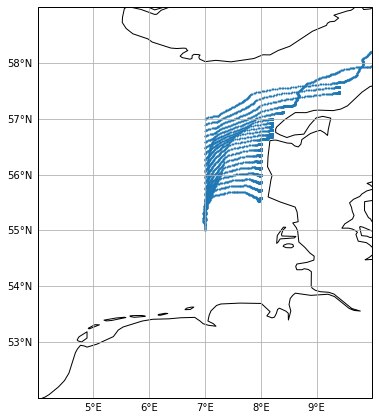

In [16]:
plt.figure(figsize=(6,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(ds['lon'], ds['lat'], s=1, transform=ccrs.PlateCarree()) #marker='o'
ax1.set_xlim([4, 10])
ax1.set_ylim([52, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

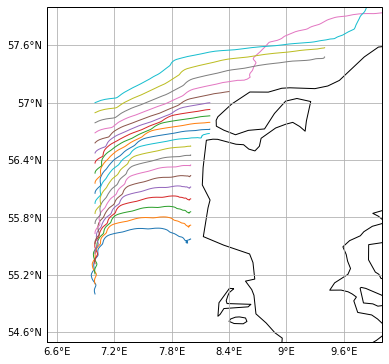

In [17]:
plt.figure(figsize=(6,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.plot(ds['lon'].T, ds['lat'].T, '-', linewidth=1, transform=ccrs.PlateCarree()) #marker='o'
ax1.set_xlim([6.5, 10])
ax1.set_ylim([54.5, 58])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# --> seems to follow bathymetry : https://images.app.goo.gl/6oAd4RHiyZB5Pysa7

### 4.1.1 Plot with velocity data below:

In [18]:
ds_vel = xr.open_mfdataset(data_path_v01 + fname_v01)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


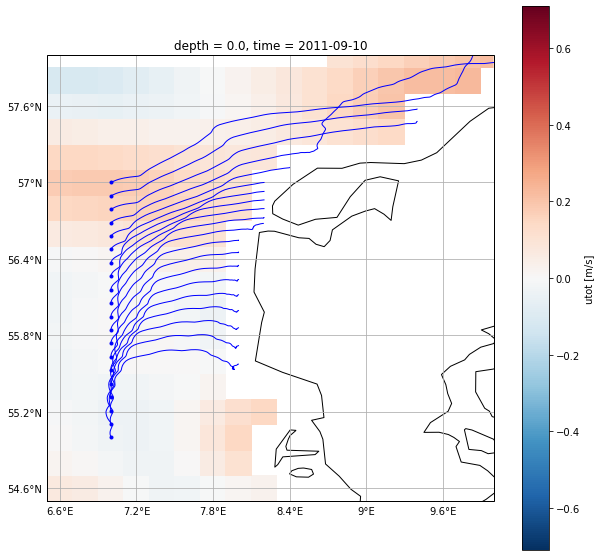

In [19]:
plt.figure(figsize=(10,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')

ds_vel.utot[216,0,:,:].plot(ax=ax1)

ax1.plot(ds['lon'].T, ds['lat'].T, '-b', linewidth=1, transform=ccrs.PlateCarree()) #marker='o'
ax1.plot(ds['lon'][:,0], ds['lat'][:,0], '.b', linewidth=1, transform=ccrs.PlateCarree()) #marker='o'

ax1.set_xlim([6.5, 10])
ax1.set_ylim([54.5, 58])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


# --> particles cross land??

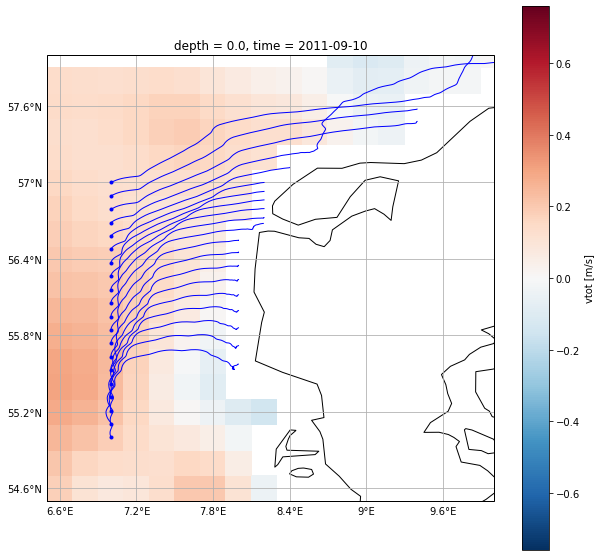

In [20]:
plt.figure(figsize=(10,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')

ds_vel.vtot[216,0,:,:].plot(ax=ax1)

ax1.plot(ds['lon'].T, ds['lat'].T, '-b', linewidth=1, transform=ccrs.PlateCarree()) #marker='o'
ax1.plot(ds['lon'][:,0], ds['lat'][:,0], '.b', linewidth=1, transform=ccrs.PlateCarree()) #marker='o'

ax1.set_xlim([6.5, 10])
ax1.set_ylim([54.5, 58])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

